# 6. Ordinary differential equations I

```{admonition} Additional resource
:class: warning
[Dan Fortunato's talk: Modern spectral methods](https://danfortunato.com/talks/ModernSpectralMethods.pdf)
```

## 6.1 Some basics 

Most numerical libraries will let you call well-established methods to solve _initial value problems_. These are (ordinary) differential equations with _complementary conditions_ that are posed at the start of the solution range. _Boundary value problems_ impose conditions at either end of this interval.

Any higher-order IVP may be written in the form

\begin{align}
\mathbf{u}'(t) &= f(\mathbf{u}(t)), \quad t \in [a, b], \\
\mathbf{u}(a) &= \mathbf{u}_0. 
\end{align}

```{admonition} Question
How? 
```

This can be done by adding higher-order derivatives to the unknown vector $\mathbf{u}$, and, if there are any explicit functions of the independent variable $t$, then adding $t$ itself to $\mathbf{u}$ as well. Usually, methods will require you to write your ODE as a first-order system of ODEs like above.

The three things required of an IVP solver are:
* A method to approximate / forecast the unknown $u$ with,
* A method to estimate the error of this approximation,
* And a method that uses this error estimate to control parameters of the solver so as to keep the error below a user-specified _tolerance_.

## 6.2 Spectral collocation methods

Most large numerical libraries will have a _Runge--Kutta_ method as a default ODE (initial value problem) solver. We'll talk about these later, but for now, the important things to know are:
- These methods are time-steppers, meaning they start from some initial conditions and approximate the solution in chunks called _timesteps_ (usually the independent variable is interpreted as timelike),
- The convergence rate of each step's approximation is $p$-th order, with $p \lessapprox 8$, usually $p = 5$.
  
```{admonition} Question
What does this mean for the error vs effort graph? 
```

Runge-Kutta methods can be extremely efficient for well-behaved initial value problems at low-to-moderate accuracy requirements. When high accuracy is demanded however (around $10^{-10}$ relative error or less), their $p$th order ($p \leq 8$) convergence is too slow. Larger $p$ for a Runge-Kutta method requires too many stages (thus too many function evaluations) to be efficient. 

For smooth solutions, spectral methods come to the rescue. **Spectral** in this context means that the method's convergence rate is determined by the smoothness of the solution. Typically, they'll achieve the following rates:

|    Smoothness of soln   |   Convergence rate   |
| :-------- | -------: |
| $C^m$ | $\mathcal{O}(n^{-m})$ |
| $C^{\infty}$ | $\mathcal{O}(n^{-m})$ for _all_ $m > 0$ |
| analytic | $\mathcal{O}(c^{-n})$ for const $c$ |

The basic idea is to turn our ODE and supplementary information (boundary, initial, or mixed) into a (sequence of) linear system(s) to solve. Starting from the simplest example,

\begin{align}
u' &= f(t), \quad t \in [a, b], \\
u(a) &= u_0,
\end{align}

where $u$ is a scalar-valued unknown function of $t$, we first discretize this function. There are two schools of thought for $u$'s representation. The first, called **nodal**, **pseudospectral**, or **collocation**, is

$$ u(t) = \sum_{j=0}^n u_j l_j(t), \quad u_j = u(t_j) \quad \text{for } j=0, 1, \ldots $$

where $l_j(t)$ are the familiar Lagrange basis polynomials, and $u_j$ are evaluations of $u$ at the nodes $\{t_j\}_{j=0}^n$. In this representation, the function is represented directly by its values at some sample nodes. The alternative, **modal**, **spectral**, or **frequency-domain** projects $u$ onto a set of orthogonal (potentially with respect to a weight function) functions $\phi_j(t)$,

$$ u(t) = \sum_{j=0}^n \hat{u}_j \phi_j(t) \quad \hat{u}_j = \frac{\langle u, \phi_j \rangle }{\langle \phi_j \phi_j \rangle} \quad \text{for }j=0, 1, \ldots, n, $$

where the angled brackets denote taking the inner product (with the appropriate weight). Here, the function is represented via an appropriately chosen basis. Typically, we'll pick

$$ t_j = -1 + \frac{2j}{n}, \quad \phi_j(t) = e^{i\pi j t}$$

for periodic $u$ and 

$$ t_j = \cos\left(\frac{j\pi}{n}\right), \quad \phi_j(t) = T_j(t) = \cos(j\cos^{-1}(t)), $$ 

where the $T_j$ are Chebyshev polynomials of the first kind. Below, we'll stick to the first (nodal) representation, but the best implementations out there exploit the advantages of both and use _fast transforms_ to convert between them when needed.

```{admonition} Question
Why are the above nodes and bases good choices? (Think back to interpolation/quadrature!)
```

Now that $u$ has been discretized, we need to do the same with $u'$. We turn the differentiation operator into a matrix $D$ which acts on the $u(t_j)$ to return $u'(t_j)$,

$$ 
D^{(n)}\begin{bmatrix} u_0 \\ u_1 \\ \vdots \\ u_n \end{bmatrix} =
\begin{bmatrix} u'_0 \\ u'_1 \\ \vdots \\ u'_n \end{bmatrix}.
$$

This matrix may be filled in an efficient and backwards-stable manner according to [Ch. 6 of Trefethen's Spectral Methods in MATLAB](https://epubs.siam.org/doi/book/10.1137/1.9780898719598). 

```{admonition} Question
What can you say about the elements (think: sparsity) of this matrix? Hint: think about what each element of $D$ expresses in terms of the elements of the $u$ and $u'$ vector. 
```

The $D$ matrix is _dense_ in the nodal representation. This is because $D$ expresses the influence of each of the $u$ evaluations on the value of $u'$ at a given point. You can imagine that at least for close-by nodes, the local behavior of $u$ will affect the value of $u'$ at the equivalent node, so the corresponding elements of $D$ will not be zero. On the other hand, differentiation is a _sparse_ operation in frequency space: for example, differentiation will not mix individual Fourier components, so the $D$ matrix in that basis is diagonal. This is an argument for using the modal representation when taking derivatives, but other operations (e.g. evaluating nonlinear elements in an ODE) is better done in the nodal representation.

```{admonition} Question
What's the shape of $D$? Is that really the most memory-efficient shape it can have (can we reduce its size)? Hint: consider the action of $D$ on a degree-$n$ polynomial. 
```

Even though above, $D \in \mathbb{R}^{(n+1) \times (n+1)}$ was a square matrix, it really should be rectangular. A degree-$n$ polynomial, represented via $n+1$ points, gets turned into a degree-$n-1$ one upon the action of $D$, which only requires $n$ nodes to pin down. Therefore if we wanted, we could make $D \in \mathbb{R}^{(n) \times (n+1)}$, e.g. following [(Driscoll & Hale 2015)](https://academic.oup.com/imajna/article-abstract/36/1/108/2363563). 

Let's see spectral differentiation in action!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as si

def chebD(n):
    """
    Computes the (n+1)x(n+1) spectral differentiation matrix\
    using Chebyshev roots according to Ch 6 of Trefethen's\
    "Spectral methods in MATLAB". Returns D and nodes on [-1, 1].
    Note that they are ordered backwards, i.e. 1 to -1!
    """
    if n == 0:
        x = 1; D = 0; w = 0
    else:
        a = np.linspace(0.0, np.pi, n+1)
        x = np.cos(a)
        b = np.ones_like(x)
        b[0] = 2; b[-1] = 2
        d = np.ones_like(b)
        d[1::2] = -1
        c = b*d
        X = np.outer(x, np.ones(n+1))
        dX = X - X.T
        D = np.outer(c, 1/c) / (dX + np.identity(n+1))
        D = D - np.diag(D.sum(axis=1))
    return D, x

In [2]:
f1 = lambda x: 1/(1 + 0.5*x**2) # This function has a pole near the interval [-1, 1]
df1 = lambda x: -x*f1(x)**2
f2 = lambda x: np.cos(5*x) # This function is entire
df2 = lambda x: -5*np.sin(5*x)

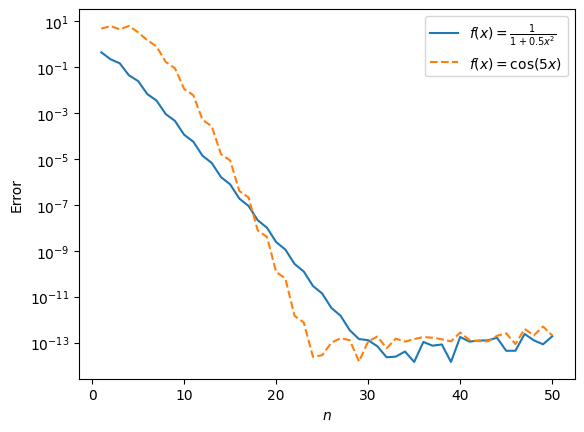

In [3]:
# Let's see how accuracy varies with n.
# We differentiate f1 and f2 on [-1, 1] and compare the numerically computed answer at the n+1 
# Chebyshev roots with the analytic one. We plot the maximum error against n.
N = 50
ns = np.arange(1, N+1, 1, dtype = int)
errs1 = np.zeros(N); errs2 = np.zeros(N)
for i, n in enumerate(ns):
    D, x = chebD(n)
    df1_num = D @ f1(x); df2_num = D @ f2(x)   
    df1_ana = df1(x); df2_ana = df2(x)
    errs1[i] = max(np.abs(df1_num - df1_ana))
    errs2[i] = max(np.abs(df2_num - df2_ana))

plt.figure()
plt.semilogy(ns, errs1, label = "$f(x) = \\frac{1}{1 + 0.5x^2}$")
plt.semilogy(ns, errs2, '--', label = "$f(x) = \cos(5x)$")
plt.xlabel("$n$")
plt.ylabel("Error")
plt.legend()
plt.show()

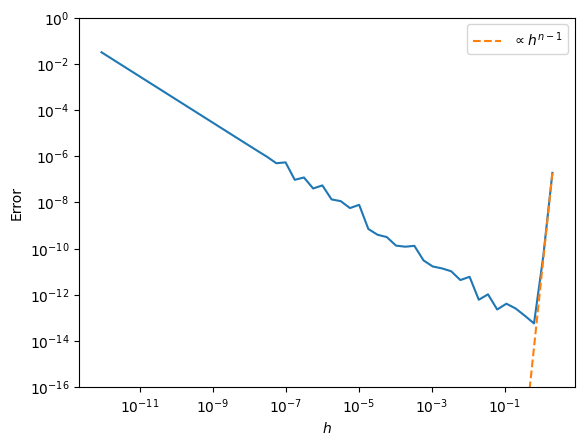

In [4]:
# Now see how the interval width, h, affects accuracy.
H = 40
n = 16
hs = np.logspace(1, -H, num = N, base = 2)
errs = np.zeros(N)
D, x = chebD(n)
for i, h in enumerate(hs):
    x_scaled = h*x/2 # We scale the nodes to be between [-h/2, h/2]
    df1_num = 2/h*(D @ f1(x_scaled)) # Note the scaling of the derivative
    df1_ana = df1(x_scaled)
    errs[i] = max(np.abs((df1_num - df1_ana)))

plt.figure()
plt.loglog(hs, errs)
plt.loglog(hs, hs**(n-1)*errs[0]/hs[0]**(n-1), '--', label = "$\propto h^{n-1}$")
plt.xlabel("$h$"); plt.ylabel("Error"); plt.ylim(1e-16, 1e-0)
plt.legend()
plt.show()

```{admonition} Question
What did we observe in the above:
1. What's the convergence rate in terms of $n$?
2. How do you explain the initial quick convergence rate in $h$ as it is reduced? What happens when $h$ gets small, and why?
```

We clearly have exponential convergence in $n$ for the function with the nearby pole, and an even faster rate for the function that is entire. Great! Note, however, that large $D$-s are ill-conditioned.

In terms of $h$, we initially see the error drop sharply as $h^{n-1}$. As the nodes get closer togeter with $h$ shrinking, roundoff error slowly accumulates $\propto h^m$, where $m$ is the order of differentiation.

We now discretized our ODE as

$$ 
\begin{bmatrix}
D_{00} & \ldots & D_{0n} \\
\vdots & \ddots & \vdots \\
D_{n0} & \ldots & D_{nn}
\end{bmatrix}
\begin{bmatrix}
u_0 \\ u_1 \\ \vdots \\ u_n
\end{bmatrix} = 
\begin{bmatrix}
f_0 \\ f_1 \\ \vdots \\ f_n
\end{bmatrix}.
$$

This of course doesn't have a unique solution until we encode the condition $u(a) = u_0$.

```{admonition} Question
How do we do that?
```

The easiest way is to replace the first row of $D$ with $[1 \; 0 \ldots 0]$, and the right-hand-side with the condition,

$$ 
\begin{bmatrix}
1 & \ldots & 0 \\
\vdots & \ddots & \vdots \\
D_{n0} & \ldots & D_{nn}
\end{bmatrix}
\begin{bmatrix}
u_0 \\ u_1 \\ \vdots \\ u_n
\end{bmatrix} = 
\begin{bmatrix}
u_0 \\ f_1 \\ \vdots \\ f_n
\end{bmatrix},
$$

but we could have also appended a row (that, however, has the disadvantage of turning the system into a rectangular one, with fewer efficient numerical solvers available). 

```{admonition} Question
Find the linear system encoding the following problems on $t \in [-1, 1]$:
1. $ u' + a(t)u = 0 $, with $u(-1) = u_0$,
2. $ u'' = f(t) $,
3. $ u'' + f(t)u = 0$, with $u(-1) = u_0$ and $u'(-1) = u'_0$.
```

Repeated differentiation can be done by the repeated application of $D$, e.g. $u'' = D^2 u$. 

Neumann conditions are most easily added by appending the relevant row of $D$ to the left-hand-side, e.g. $u'(-1) = u'_0$ may be written as 
\begin{equation}
\begin{bmatrix} D_{00} & D_{01} & \ldots  & D_{0n} \end{bmatrix}
\begin{bmatrix} u_0 \\ u_1 \\ \vdots \\ u_n \end{bmatrix}
= u'_0.
\end{equation}

Every good numerical method needs to measure its own error. 

```{admonition} Question
Propose a way of measuring the error of the $(n+1)$-node spectral solution of 
$$ u'' + \omega^2 u = 0, \quad u(-1) = 1, \quad u'(-1) = 0, \quad t \in [-1, 1]. $$
```

The easiest way to estimate the error of a spectral method in practice is to increase the number of nodes and compare the answers. However, nodes may not fall on top of each other, in which case one has to resort to interpolation. In the special case of initial value problems, we can exploit the fact that $\pm 1$ will always be nodes at any value of $n$, and we may compare the answers at whichever node $u$ is not given.

We are ready to code up a prototype of a spectral collocation method and compare its performance against a lower-order Runge-Kutta method.

```{admonition} Exercise
:class: danger

You'll solve 
$$ u'' + \omega^2 u = 0, \quad u(-1) = 1, \quad u'(-1) = 0, \quad t \in [-1, 1], $$
which corresponds to a simple harmonic oscillator with constant frequency $\omega = 100$.

* a) First, write a function `f_ivp(t, u)` that encodes this ODE as a system of first-order ODEs and returns the derivative of the vector of unknowns, `u`. It need not have a detailed docstring.
* b) Then define the initial conditions and solution interval. Call `scipy.integrate.solve_ivp` or a similar method (that uses a default Runge--Kutta) to solve the IVP to about 12 digits of accuracy. Think about whether it makes sense to set a relative tolerance, an absolute tolerance, or both. 
* c) Time the solution and print the result.

Now we'll solve the IVP with a spectral method. 
* d) Write down the discretized version of the ODE, then the whole IVP (i.e., augmented with the initial conditions) using the differentiation matrix $D$. 
* e) Using the `chebD` function from your first quiz, write a function `solve(n)` that encodes the discretized ODE and initial conditions with (n+1)-node collocation, and solves the resulting (rectangular) linear system with `numpy`'s (or MATLAB's) least squares method. This function needs to have a nice docstring.
* f) Write a function `solve_spectral(tol)` that takes in an absolute tolerance `tol`, and calls `solve(n)` with double the `n` on each iteration, until it either reaches `n = 256` or the solution $u$ (the first element of the unknown vector) at the end of the solution interval until it converges to within the absolute tolerance. (Compare it to the solution from the previous iteration.)
* g) Time this method as well. Comment on how it compares to the Runge--Kutta method.
```

## 6.2 Implementations of spectral methods

A number of packages exist that implement spectral differentiation, quadrature, ODE and PDE solvers:

- Python: 
    - [Dedalus](https://dedalus-project.org)
- MATLAB:
    - [chenfun](https://www.chebfun.org), [ultraSEM](https://github.com/danfortunato/ultraSEM)
- Julia: 
    - [ApproxFun](https://juliaapproximation.github.io/ApproxFun.jl/latest/)